Importing NASAs Li-ion Battery Aging Datasets

In [122]:
%matplotlib inline
!wget https://phm-datasets.s3.amazonaws.com/NASA/5.+Battery+Data+Set.zip -O battery_data.zip
!unzip -o battery_data.zip 
!rm battery_data.zip
!cd "5. Battery Data Set" 
!find "5. Battery Data Set" -name "*.zip" -execdir unzip -oq {} \;

--2023-03-27 02:19:23--  https://phm-datasets.s3.amazonaws.com/NASA/5.+Battery+Data+Set.zip
Resolving phm-datasets.s3.amazonaws.com (phm-datasets.s3.amazonaws.com)... 3.5.1.132, 54.231.225.105, 52.217.196.121, ...
Connecting to phm-datasets.s3.amazonaws.com (phm-datasets.s3.amazonaws.com)|3.5.1.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209708670 (200M) [application/zip]
Saving to: ‘battery_data.zip’

battery_data.zip    100%[===================>] 199.99M  77.2MB/s    in 2.6s    

2023-03-27 02:19:26 (77.2 MB/s) - ‘battery_data.zip’ saved [209708670/209708670]

Archive:  battery_data.zip
  inflating: 5. Battery Data Set/1. BatteryAgingARC-FY08Q4.zip  
  inflating: 5. Battery Data Set/2. BatteryAgingARC_25_26_27_28_P1.zip  
  inflating: 5. Battery Data Set/3. BatteryAgingARC_25-44.zip  
  inflating: 5. Battery Data Set/4. BatteryAgingARC_45_46_47_48.zip  
  inflating: 5. Battery Data Set/5. BatteryAgingARC_49_50_51_52.zip  
  inflating: 5. Battery Data

In [123]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [124]:
def load_data(battery):
  mat = loadmat('5. Battery Data Set/' + battery + '.mat')
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]

      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1

  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

t_ds, t_c_ds = load_data('B0005')
v_ds, v_c_ds = load_data('B0006')

Preprocessing


In [125]:
# removing columns with constant values
def remove_constant_columns(ds):
  for col in ds.columns:
    if ds[col].unique().size == 1:
      dropped_cols = ds.drop([col], axis=1, inplace=True)
      print(dropped_cols)
  return ds

t_ds = remove_constant_columns(t_ds)
v_ds = remove_constant_columns(v_ds)

#dtype inspection
t_ds.dtypes
v_ds.dtypes

#datatime is annoying
t_ds.drop(['datetime'], axis=1, inplace=True)
v_ds.drop(['datetime'], axis=1, inplace=True)

#replacing spaces with underscores
# t_ds.replace(' ', '_', regex=True, inplace=True)
# v_ds.replace(' ', '_', regex=True, inplace=True)

None
None


Splitting Datasets

In [126]:
#training datasets
t_X = t_ds.drop(['capacity'], axis=1)
t_y = t_ds['capacity'].copy()

#verification datasets
v_X = v_ds.drop(['capacity'], axis=1)
v_y = v_ds['capacity'].copy()


Prediction Function

In [127]:
def pred(model, verification_ds):
    
    predicted_ds = model.predict(verification_ds)
    return predicted_ds

Graphing Function

In [128]:
def graph(predicted, actual):
    plt.plot(predicted, label='verification_predicted')
    plt.plot(actual, label='verification_acutal')
    plt.xlabel('cycles')
    plt.ylabel('capacity')
    plt.legend()
    plt.show()

Linear Regression Model

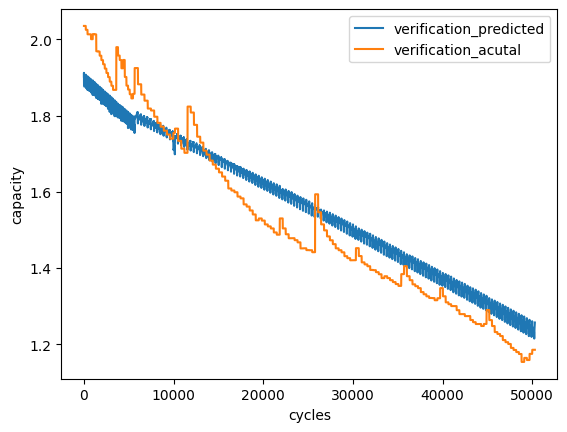

In [129]:
# Create a linear regression object
lr = LinearRegression()

# Train the model using the training data
lr.fit(t_X, t_y)

#Prediction
lr_pred = pred(lr, v_X) 

# Graph
graph(lr_pred, v_y)


Random Forest Regression Model

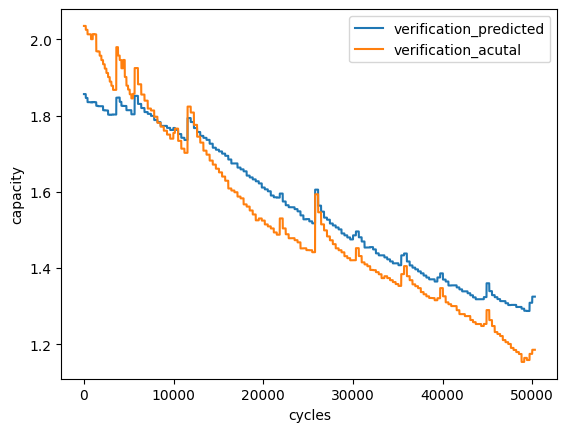

In [130]:
# Create a random forest regressor object
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the model using the training data
rf.fit(t_X, t_y)

# Prediction
rf_pred = pred(rf, v_X)

# Graph
graph(rf_pred, v_y)


creds to https://www.kaggle.com/rajeevsharma993 to help me get started